<a href='https://github.com/SeWonKwon' ><div> <img src ='https://slid-capture.s3.ap-northeast-2.amazonaws.com/public/image_upload/6556674324ed41a289a354258718280d/964e5a8b-75ad-41fc-ae75-0ca66d06fbc7.png' align='left' /> </div></a>


source : https://www.kaggle.com/c/mercari-price-suggestion-challenge/data

googledrive download link : https://drive.google.com/file/d/1W3qtrtcbkCP3Tgnx56r0EHWF421qj-dF/view?usp=sharing

# column 정보


* **train_id or test_id** - the id of the listing

* **name** - the title of the listing. Note that we have cleaned the data to remove text that look like prices (e.g. \$20) to avoid leakage. These removed prices are represented as `[rm]`

* **item_condition_id** - the condition of the items provided by the seller

* **category_name** - category of the listing

* **brand_name**

* **price** - the price that the item was sold for. This is the target variable that you will predict. The unit is USD. This column doesn't exist in test.tsv since that is what you will predict.

* **shipping** - 1 if shipping fee is paid by seller and 0 by buyer

* **item_description** - the full description of the item. Note that we have cleaned the data to remove text that look like prices (e.g. $20) to avoid leakage. These removed prices are represented as `[rm]`


# get data

In [1]:
import pandas as pd

df = pd.read_csv('./data/train.tsv', sep='\t')
df.head(3)

,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description
0,0,MLB Cincinnati Reds T Shirt Size XL,3,Men/Tops/T-shirts,NaN,10.0,1,No description yet
1,1,Razer BlackWidow Chroma Keyboard,3,Electronics/Computers & Tablets/Components & P...,Razer,52.0,0,This keyboard is in great condition and works ...
2,2,AVA-VIV Blouse,1,Women/Tops & Blouses/Blouse,Target,10.0,1,Adorable top with a hint of lace and a key hol...
3,3,Leather Horse Statues,1,Home/Home Décor/Home Décor Accents,NaN,35.0,1,New with tags. Leather horses. Retail for [rm]...
4,4,24K GOLD plated rose,1,Women/Jewelry/Necklaces,NaN,44.0,0,Complete with certificate of authenticity
...,...,...,...,...,...,...,...,...
1482530,1482530,Free People Inspired Dress,2,Women/Dresses/Mid-Calf,Free People,20.0,1,"Lace, says size small but fits medium perfectl..."
1482531,1482531,Little mermaid handmade dress,2,Kids/Girls 2T-5T/Dresses,Disney,14.0,0,Little mermaid handmade dress never worn size 2t
1482532,1482532,21 day fix containers and eating plan,2,Sports & Outdoors/Exercise/Fitness accessories,NaN,12.0,0,"Used once or twice, still in great shape."
1482533,1482533,World markets lanterns,3,Home/Home Décor/Home Décor Accents,NaN,45.0,1,There is 2 of each one that you see! So 2 red ...


In [11]:
def get_df_info(df, short=False):
    print('데이터 세트의 Shape:', df.shape)
    print('\n전체 피처의 dtype\n', df.dtypes.value_counts())
    isnull_series = df.isnull().sum()
    null_column_count = df.isnull().sum()[df.isnull().sum()>0]
    df_null = pd.DataFrame({'dtype':df.dtypes[null_column_count.index], 'null_count':df.isnull().sum()[df.isnull().sum()>0]})
    df_null['null_per'] = df_null['null_count'].apply(lambda x : round(x*100/df.shape[0], 2))
    if short:
        display(df_null.sort_values('null_count',ascending=False).head())
        display(df.describe().T.head())
    else:
        display(df_null.sort_values('null_count',ascending=False))
        display(df.describe().T)

In [12]:
get_df_info(df)

데이터 세트의 Shape: (1482535, 8)

전체 피처의 dtype
 object     4
int64      3
float64    1
dtype: int64


,dtype,null_count,null_per
brand_name,object,632682,42.68
category_name,object,6327,0.43
item_description,object,4,0.00


,count,mean,std,min,25%,50%,75%,max
train_id,1482535.0,741267.000000,427971.135004,0.0,370633.5,741267.0,1111900.5,1482534.0
item_condition_id,1482535.0,1.907380,0.903159,1.0,1.0,2.0,3.0,5.0
price,1482535.0,26.737516,38.586066,0.0,10.0,17.0,29.0,2009.0
shipping,1482535.0,0.447274,0.497212,0.0,0.0,0.0,1.0,1.0


* brand_name : 많은 Null 값(42%)

# target 값 확인

In [14]:
df.price.aggregate(['min', 'max','std','mean'])

min        0.000000
max     2009.000000
std       38.586066
mean      26.737516
Name: price, dtype: float64

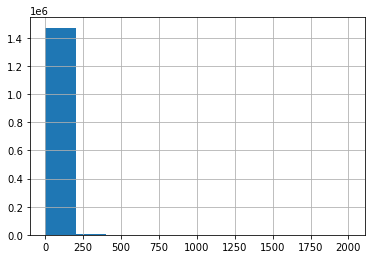

In [20]:
df.price.hist();

target 값 자체가 많이 skewed 되어 있으므로, 우선 log1p 변환해서 확인해 보자. 

In [21]:
import numpy as np 

df['price_log'] = df['price'].apply(lambda x : np.log1p(x))

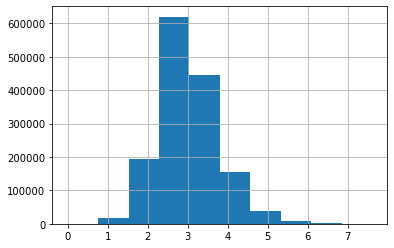

In [22]:
df.price_log.hist();

바로 이쁜 정규 분포로 변환 된것을 볼수 있다. 타겟값은 log1p변환으로 사용하기로 한다. 

In [24]:
df.columns

Index(['train_id', 'name', 'item_condition_id', 'category_name', 'brand_name',
       'price', 'shipping', 'item_description', 'price_log'],
      dtype='object')

# item_condition_id

In [25]:
df['item_condition_id']

0          3
1          3
2          1
3          1
4          1
          ..
1482530    2
1482531    2
1482532    2
1482533    3
1482534    1
Name: item_condition_id, Length: 1482535, dtype: int64

In [26]:
df['item_condition_id'].value_counts()

1    640549
3    432161
2    375479
4     31962
5      2384
Name: item_condition_id, dtype: int64

# category_name

In [27]:
df['category_name']

0                                          Men/Tops/T-shirts
1          Electronics/Computers & Tablets/Components & P...
2                                Women/Tops & Blouses/Blouse
3                         Home/Home Décor/Home Décor Accents
4                                    Women/Jewelry/Necklaces
                                 ...                        
1482530                               Women/Dresses/Mid-Calf
1482531                             Kids/Girls 2T-5T/Dresses
1482532       Sports & Outdoors/Exercise/Fitness accessories
1482533                   Home/Home Décor/Home Décor Accents
1482534                    Women/Women's Accessories/Wallets
Name: category_name, Length: 1482535, dtype: object

In [37]:
'Women/Athletic Apparel/Pants, Tights, Leggings'.count('/')

2

In [44]:
df['category_name'].isnull().sum()

6327

In [46]:
df['count_cat_name'] = df['category_name'].apply(lambda x : str(x).count('/'))
df['count_cat_name'].value_counts()

2    1471819
0       6327
4       3059
3       1330
Name: count_cat_name, dtype: int64

In [32]:
df['cat_1'] = df['category_name'].apply(lambda x : str(x).split('/')[0])

IndexError: list index out of range

In [31]:
df['cat_1'].value_counts()

Women                     664385
Beauty                    207828
Kids                      171689
Electronics               122690
Men                        93680
Home                       67871
Vintage & Collectibles     46530
Other                      45351
Handmade                   30842
Sports & Outdoors          25342
nan                         6327
Name: cat_1, dtype: int64

In [48]:
def split_cat(category_name):
    try:
        return category_name.split('/')
    except:
        return ['Other_null', 'Other_null', 'Other_Null']
    
df['cat_dae'], df['cat_jung'], df['cat_so'] = zip(*df['category_name'].apply(lambda x : split_cat(x)))

In [49]:
df['cat_dae'].value_counts()

Women                     664385
Beauty                    207828
Kids                      171689
Electronics               122690
Men                        93680
Home                       67871
Vintage & Collectibles     46530
Other                      45351
Handmade                   30842
Sports & Outdoors          25342
Other_null                  6327
Name: cat_dae, dtype: int64

In [50]:
df['cat_jung'].value_counts()

Athletic Apparel        134383
Makeup                  124624
Tops & Blouses          106960
Shoes                   100452
Jewelry                  61763
                         ...  
Candles                     64
Ceramics and Pottery        57
Dolls and Miniatures        49
Books and Zines             46
Quilts                      31
Name: cat_jung, Length: 114, dtype: int64

In [51]:
df['cat_so'].value_counts()

Pants, Tights, Leggings    60177
Other                      50224
Face                       50171
T-Shirts                   46380
Shoes                      32168
                           ...  
Four Button                    1
Pad                            1
Educational                    1
Dishwashers                    1
Tiles                          1
Name: cat_so, Length: 871, dtype: int64

# brad_name

In [23]:
df['brand_name']

0                  NaN
1                Razer
2               Target
3                  NaN
4                  NaN
              ...     
1482530    Free People
1482531         Disney
1482532            NaN
1482533            NaN
1482534            NaN
Name: brand_name, Length: 1482535, dtype: object

# item_description

In [52]:
df['item_description']

0                                         No description yet
1          This keyboard is in great condition and works ...
2          Adorable top with a hint of lace and a key hol...
3          New with tags. Leather horses. Retail for [rm]...
4                  Complete with certificate of authenticity
                                 ...                        
1482530    Lace, says size small but fits medium perfectl...
1482531     Little mermaid handmade dress never worn size 2t
1482532            Used once or twice, still in great shape.
1482533    There is 2 of each one that you see! So 2 red ...
1482534    New with tag, red with sparkle. Firm price, no...
Name: item_description, Length: 1482535, dtype: object

In [54]:
(df['item_description'] == 'No description yet').sum()

82489

# name

In [56]:
df['name']

0            MLB Cincinnati Reds T Shirt Size XL
1               Razer BlackWidow Chroma Keyboard
2                                 AVA-VIV Blouse
3                          Leather Horse Statues
4                           24K GOLD plated rose
                           ...                  
1482530               Free People Inspired Dress
1482531            Little mermaid handmade dress
1482532    21 day fix containers and eating plan
1482533                   World markets lanterns
1482534            Brand new lux de ville wallet
Name: name, Length: 1482535, dtype: object

In [57]:
df['name'].value_counts()

Bundle                                 2232
Reserved                                453
Converse                                445
BUNDLE                                  418
Dress                                   410
                                       ... 
XL Draped V-neck tee                      1
*NEW* Gameboy Advance SP/DS charger       1
MusclePharm Arnold Series Tee Shirt       1
NWT NIKE LAB Training Pants XL            1
Black VANS size 6.5                       1
Name: name, Length: 1225273, dtype: int64

**Reference**

* <a href='https://github.com/SeWonKwon' ><div> <img src ='https://slid-capture.s3.ap-northeast-2.amazonaws.com/public/image_upload/6556674324ed41a289a354258718280d/964e5a8b-75ad-41fc-ae75-0ca66d06fbc7.png' align='left' /> </div></a>

<br>

* 파이썬 머신러닝 완벽 가이드, 권철민
